# Ensayos bobina rogowski

Bibliotecas utilizadas para tratar los datos y realizar gráficas

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import pandas_bokeh

Mediciones realizadas con un osciloscopio Hantek 6022BE y el software OpenHantek6022, se exportó un fichero csv.

## Pinza vs Rogowski integrador hardware

El canal 1 es la pinza y el canal 2 es la bobina integrada. La pinza estaba midiendo una corriente multiplicada 10 veces, además de que estaba en una escala de 1mV/100mA. La bobina rogowski estaba midiendo una corriente multiplicada 50 veces.

Factor pinza = v_medido * 0.1A/(10 * 0.001V)

Factor pinza = 10

Factor bobina = v_medido/50

In [12]:
factor_pin = 10
factor_rog = 1

In [4]:
headers = ['t', 'ch1', 'ch2']
filename = "resis_50a_int_pinza"
ext = ".csv"

In [118]:
with open(filename+ext) as f:
    head = f.readline()
    frow = f.readline()
print(head+frow)

"t / s";"CH1 / V";"CH2 / V"
0;0,081901;0,02552



La primer fila del archivo contiene las cabeceras, los datos están separados por ';' y el separador decimal es ','. Se indican estos parámetros para leer el fichero en un dataframe de Pandas.

In [5]:
df = pd.read_csv (filename+ext,header=1, sep=';', decimal=',', names=headers)

Para que sea compatible con matlab se puede exportar:

In [82]:
#df.to_csv('fix'+filename+ext,index=False)

Gráfica de las mediciones:

<AxesSubplot:xlabel='t'>

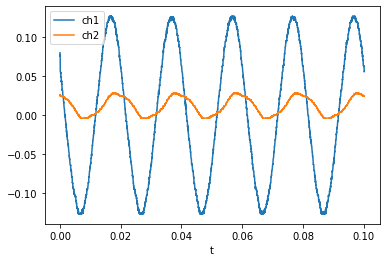

In [6]:
df.set_index('t').plot()

In [9]:
pandas_bokeh.output_file(filename+'.html')

In [10]:
df.set_index('t').plot_bokeh(kind="line")

Figure(id='1002', ...)

In [85]:
df.describe()

,t,ch1,ch2
count,10012.000000,10012.000000,10012.00000
mean,0.050065,-0.000148,0.01176
std,0.028904,0.088052,0.01136
min,0.000010,-0.126733,-0.00408
25%,0.025037,-0.087604,0.00016
50%,0.050065,0.000000,0.01196
75%,0.075093,0.088000,0.02376
max,0.100120,0.126733,0.02800


A partir de esto se puede remover el offset de las señales y escalarlas si es necesario.

<AxesSubplot:title={'center':'Rogowski vs Hantek CC-650'}, xlabel='muestras', ylabel='tensión'>

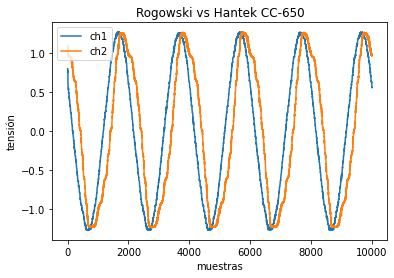

In [13]:
offset1 = df['ch1'].mean()
offset2 = df['ch2'].mean()
escala = (df['ch1'].max()-offset1)/(df['ch2'].max()-offset2)
a = (df['ch1']-offset1)*factor_pin
ax = a.plot(title='Rogowski vs Hantek CC-650',legend=True)
b = (df['ch2']-offset2)*escala*factor_pin
ax.set_ylabel('tensión')
ax.set_xlabel('muestras')
b.plot(legend=True)

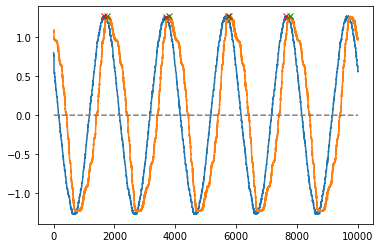

In [227]:
from scipy.signal import find_peaks
peaks1, _ = find_peaks(a, prominence=1, distance=1000)
peaks2, _ = find_peaks(b, prominence=1, distance=1000)
plt.plot(a)
plt.plot(b)
plt.plot(peaks1, a[peaks1], "x", color="red")
plt.plot(peaks2, b[peaks2], "x", color="green")
plt.plot(np.zeros_like(a), "--", color="gray")

In [241]:
print(f"los picos de ch1 estan en {peaks1}\nlos picos de ch2 están en {peaks2}")
delta = peaks2 - peaks1
print(f"los delta de muestras son {delta}")
periodo = (peaks1[2]-peaks1[1])*(t[2]-t[1])
deltafase = delta *(t[2]-t[1]) * 360 / periodo
print(f"los desfasajes son {deltafase}")

los picos de ch1 estan en [1668 3693 5724 7651]
los picos de ch2 están en [1753 3792 5757 7768]
los delta de muestras son [ 85  99  33 117]
los desfasajes son [15.06646972 17.54800591  5.8493353  20.73855244]


La bobina rogowski estaba midiendo una corriente 5 veces mayor que la pinza, por lo tanto el factor de escala es:

In [292]:
factor_rog = escala * factor_pin * 5
factor_rog

390.6395594252939

# Pinza vs Rogowski integrada numéricamente

In [15]:
filename = "resis50_pinza_di"
ext = ".csv"
df2 = pd.read_csv (filename+ext,header=1, sep=';', decimal=',', names=headers)

<AxesSubplot:xlabel='t'>

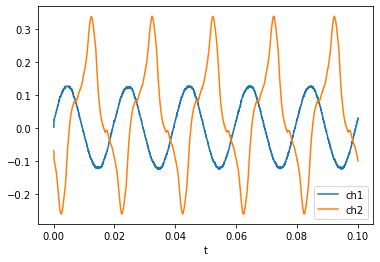

In [16]:
df2.set_index('t').plot()

In [17]:
pandas_bokeh.output_file(filename+'.html')
df2.set_index('t').plot_bokeh(kind="line")

Figure(id='1423', ...)

In [18]:
x2 = df2.ch2.to_numpy()
x2 = x2 - df2['ch2'].mean()
t = df2.t.values.tolist()
integral = np.zeros(len(x2))

In [19]:
for j in range(1,len(x2)-1):
    ac = (t[j+1]-t[j])*x2[j]
    at = (t[j+1]-t[j])*(x2[j+1]-x2[j])/2
    integral[j+1] = ac + at + integral[j]

In [30]:
x1 = df2.ch1.to_numpy()
x3 = -integral*190-0.07

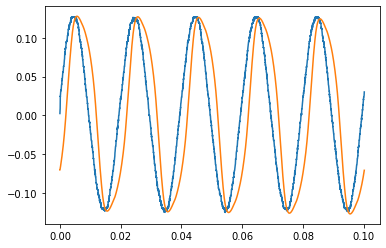

In [31]:
plt.plot(t,x1,t,x3)

In [37]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, save, output_file

In [40]:
output_file(filename=filename+'.html', title="Integración Numérica Rogowski")
p = figure(
    title="Rogowski int. num. vs Hantek CC-650",
    x_axis_label="x",
    y_axis_label="y",
    tooltips="(@x, @y)",
    sizing_mode='stretch_height'
    )
p.line(t, x1, legend_label="Pinza", line_color="blue")
p.line(t, x3, legend_label="Rogowski", line_color="green")
show(p)
save(p)

'c:\\Users\\Daniel\\Desktop\\mediciones_rogowski\\resis50_pinza_di.html'

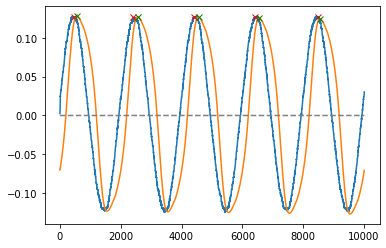

In [265]:
peaks1, _ = find_peaks(x1, prominence=.1, distance=1000)
peaks2, _ = find_peaks(x3, prominence=.1, distance=1000)
plt.plot(x1)
plt.plot(x3)
plt.plot(peaks1, x1[peaks1], "x", color="red")
plt.plot(peaks2, x3[peaks2], "x", color="green")
plt.plot(np.zeros_like(x1), "--", color="gray")

In [266]:
print(f"los picos de ch1 estan en {peaks1}\nlos picos de ch2 están en {peaks2}")
delta = peaks2 - peaks1
print(f"los delta de muestras son {delta}")
periodo = (peaks1[2]-peaks1[1])*(t[2]-t[1])
deltafase = delta *(t[2]-t[1]) * 360 / periodo
print(f"los desfasajes son {deltafase}")

los picos de ch1 estan en [ 477 2404 4403 6412 8483]
los picos de ch2 están en [ 562 2561 4559 6558 8556]
los delta de muestras son [ 85 157 156 146  73]
los desfasajes son [15.30765383 28.27413707 28.09404702 26.29314657 13.14657329]


# Bobina Rogowski con carga resistiva conocida

<AxesSubplot:xlabel='t'>

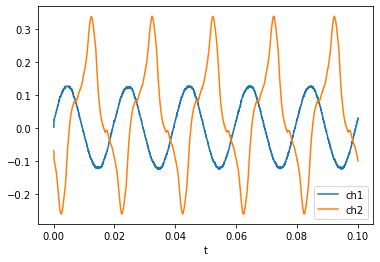

In [26]:
filename = "resis50_pinza_di"
ext = ".csv"
df3 = pd.read_csv (filename+ext,header=1, sep=';', decimal=',', names=headers)
df3.set_index('t').plot()

In [27]:
df3.describe()

,t,ch1,ch2
count,10012.000000,10012.000000,10012.000000
mean,0.050065,0.001857,0.036588
std,0.028904,0.087380,0.161143
min,0.000010,-0.124594,-0.260360
25%,0.025037,-0.086733,-0.071600
50%,0.050065,0.000079,0.032620
75%,0.075093,0.088317,0.140080
max,0.100120,0.126812,0.339800


El canal 1 es la tensión aplicada sobre la resistencia de potencia, fue medida con una atenuacion de 100 veces, se tiene entonces la corriente 'real'. El canal 2 es la corriente medida por la bobina Rogowski, se aplica el factor de escala.

In [298]:
att_probe = 100
rohm = 120
df3['ch1'] = df3['ch1']*att_probe/rohm

In [295]:
df3['ch2'] = (df3['ch2']-0.012) * factor_rog / 5

<AxesSubplot:xlabel='t'>

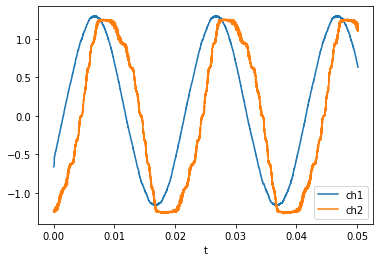

In [299]:
df3.set_index('t').plot()

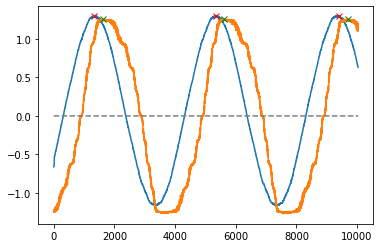

In [300]:
i1 = df3.ch1.to_numpy()
i2 = df3.ch2.to_numpy()
peaks1, _ = find_peaks(i1, prominence=.1, distance=1000)
peaks2, _ = find_peaks(i2, prominence=.1, distance=1000)
plt.plot(i1)
plt.plot(i2)
plt.plot(peaks1, i1[peaks1], "x", color="red")
plt.plot(peaks2, i2[peaks2], "x", color="green")
plt.plot(np.zeros_like(i1), "--", color="gray")

In [301]:
print(f"los picos de ch1 estan en {peaks1}\nlos picos de ch2 están en {peaks2}")
delta = peaks2 - peaks1
print(f"los delta de muestras son {delta}")
periodo = (peaks1[2]-peaks1[1])*(t[2]-t[1])
deltafase = delta *(t[2]-t[1]) * 360 / periodo
print(f"los desfasajes son {deltafase}")

los picos de ch1 estan en [1320 5362 9390]
los picos de ch2 están en [1610 5613 9685]
los delta de muestras son [290 251 295]
los desfasajes son [25.91857001 22.43296922 26.36544191]


## Funciones auxiliares

La función shift(data, n) desplaza n el array data.

La función lowpass(data, cutoff,fs,order) aplica un filtro Butterworth pasabajos de segundo orden con frecuencia de corte 'cutoff', de orden 'order'. Se debe especificar la frecuencia de muestreo.

In [336]:
def shift(data, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = data[:-n]
    else:
        e[n:] = np.nan
        e[:n] = data[-n:]
    return e

In [303]:
shift(df3.ch2,-290)

array([-0.95628564, -0.96253587, -0.97503634, ...,         nan,
               nan,         nan])

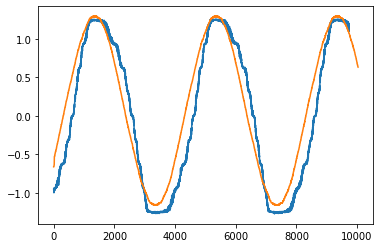

In [330]:
desfasaje = int(delta[0]*(-1))
plt.plot(shift(df3.ch2,desfasaje))
plt.plot(df3.ch1)

In [75]:
from scipy.signal import butter, filtfilt
def lowpass(data, cutoff,fs,order):
    nyq = fs * 0.5
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

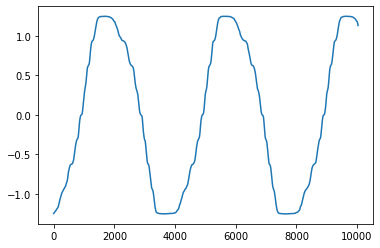

In [342]:
plt.plot(lowpass(df3.ch2, 1000, int(1/t[1]), 2))

<AxesSubplot:xlabel='t'>

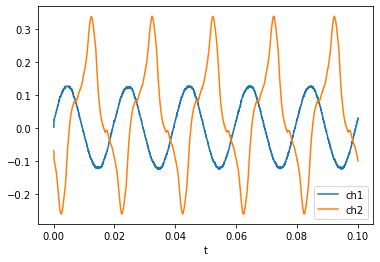

In [136]:
filename = "resis50_pinza_di"
ext = ".csv"
df3 = pd.read_csv (filename+ext,header=1, sep=';', decimal=',', names=headers)
df3.set_index('t').plot()

In [46]:
df3.describe()

,t,ch1,ch2
count,10012.000000,10012.000000,10012.000000
mean,0.050065,0.001857,0.036588
std,0.028904,0.087380,0.161143
min,0.000010,-0.124594,-0.260360
25%,0.025037,-0.086733,-0.071600
50%,0.050065,0.000079,0.032620
75%,0.075093,0.088317,0.140080
max,0.100120,0.126812,0.339800


In [137]:
df3['ch2'] = df3['ch2'] - df3.ch2.mean()

<AxesSubplot:xlabel='t'>

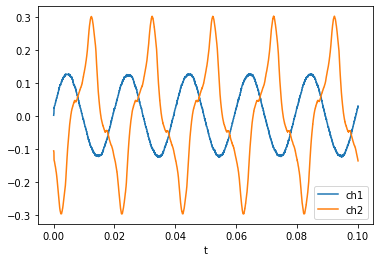

In [138]:
df3.set_index('t').plot()

In [36]:
df3.describe()

,t,ch1,ch2
count,10012.000000,10012.000000,1.001200e+04
mean,0.050065,0.001857,-1.632290e-17
std,0.028904,0.087380,1.611426e-01
min,0.000010,-0.124594,-2.969477e-01
25%,0.025037,-0.086733,-1.081877e-01
50%,0.050065,0.000079,-3.967727e-03
75%,0.075093,0.088317,1.034923e-01
max,0.100120,0.126812,3.032123e-01


In [37]:
import math

In [41]:
Imed = 50*math.sqrt(2)
print(Imed)

70.71067811865476


In [139]:
df3['ch1'] = df3['ch1']*50*10/1.2

<AxesSubplot:xlabel='t'>

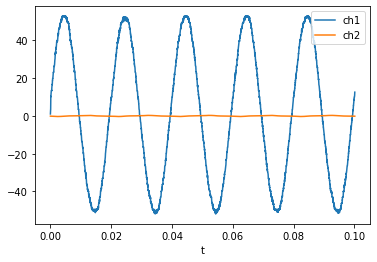

In [140]:
df3.set_index('t').plot()

In [193]:
x4 = df3.ch2.to_numpy()
x4 = lowpass(x4, 50, int(1/t[1]), 2)
t = df3.t.values.tolist()
derivada = np.zeros(len(x4))

In [194]:
for j in range(1,len(x4)-1):
    derivada[j+1] = (x4[j+1]-x4[j])/(t[j+1]-t[j])

In [195]:
x5 = df3.ch1.to_numpy()
x4 = derivada

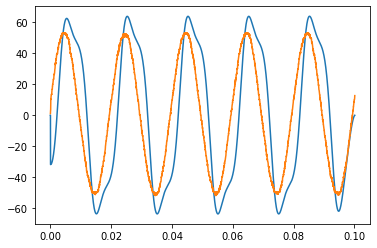

In [196]:
plt.plot(t,x4,t,x5)

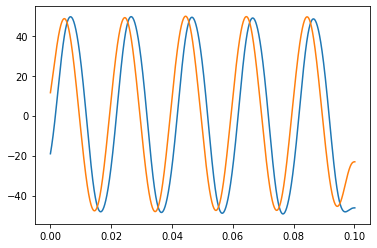

In [208]:
plt.plot(t,lowpass(x3-x3.mean(), 50, int(1/t[1]), 2)*(1/13e-6),t,lowpass(df3.ch1, 50, int(1/t[1]), 2))